# Task5

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [59]:
df = pd.read_csv('../data/movies.csv')
ratings_small = pd.read_csv('../data/ratings_small.csv')

In [60]:
df.dropna(inplace=True)
df = df.drop_duplicates().reset_index(drop=True)

In [61]:
ratings_matrix = ratings_small.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [62]:
ratings_matrix.index

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       662, 663, 664, 665, 666, 667, 668, 669, 670, 671],
      dtype='int64', name='userId', length=671)

In [63]:
# Find CB
user_id =1

from sklearn.metrics.pairwise import cosine_similarity
cb_features = ['genres','keywords','cast','crew']
df_cb = df[cb_features].fillna('').apply(lambda x: x.str.lower())  

# Convert to simple bag-of-words vectors
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
cb_matrix = vec.fit_transform(df_cb.apply(lambda x: ' '.join(x), axis=1))

# Compute similarity between all items
cb_sim = cosine_similarity(cb_matrix)

# For user, average CB scores of items they rated
user_ratings = ratings_matrix.loc[user_id]
user_rated_items = user_ratings.to_numpy().nonzero()[0]
sCB = cb_sim[user_rated_items,:].mean(axis=0) if len(user_rated_items) > 0 else np.zeros(cb_sim.shape[0])

In [64]:
# Find CF
user_ratings = ratings_matrix[user_id].copy()
user_mean = user_ratings[user_ratings > 0].mean() if np.any(user_ratings > 0) else 0
sCF = user_ratings.copy()
sCF[sCF == 0] = user_mean

In [65]:
# Map movie IDs in df to their row indices
movie_id_to_idx = {mid: i for i, mid in enumerate(df['id'])}
sCF_full = np.zeros(len(df)) 

for mid, score in sCF.items(): 
    if mid in movie_id_to_idx:
        idx = movie_id_to_idx[mid]
        sCF_full[idx] = score

In [66]:
# Normalize scores
scaler = MinMaxScaler()
sCF_norm = scaler.fit_transform(sCF_full.reshape(-1,1)).flatten()
sCB_norm = scaler.fit_transform(sCB.reshape(-1,1)).flatten()

In [67]:
alpha = 0.5  # tune on validation
s_hyb = alpha * sCF_norm + (1 - alpha) * sCB_norm

In [68]:
# List of movie IDs in order of df
item_ids = df['id'].tolist()
item_ids

[2,
 5,
 6,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 28,
 33,
 35,
 38,
 55,
 58,
 59,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 120,
 121,
 122,
 123,
 128,
 129,
 132,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 153,
 154,
 155,
 156,
 158,
 161,
 162,
 163,
 164,
 165,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 182,
 184,
 185,
 186,
 187,
 189,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 203,
 204,
 205,
 207,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 226,
 227,
 228,
 229,
 231,
 232,
 233,
 234,
 235,
 236,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249

In [69]:
# Top-10 indices
top_indices = s_hyb.argsort()[::-1][:10]

recommended_titles = [df.loc[i, 'title'] for i in top_indices]

print("Top-10 hybrid recommendations:")
print(recommended_titles)

Top-10 hybrid recommendations:
['To Die For', 'Blackmail', 'Monsoon Wedding', 'Volver', 'The Godfather: Part III', 'Italian for Beginners', 'Harold and Maude', 'Forrest Gump', 'Fargo', 'Frenzy']


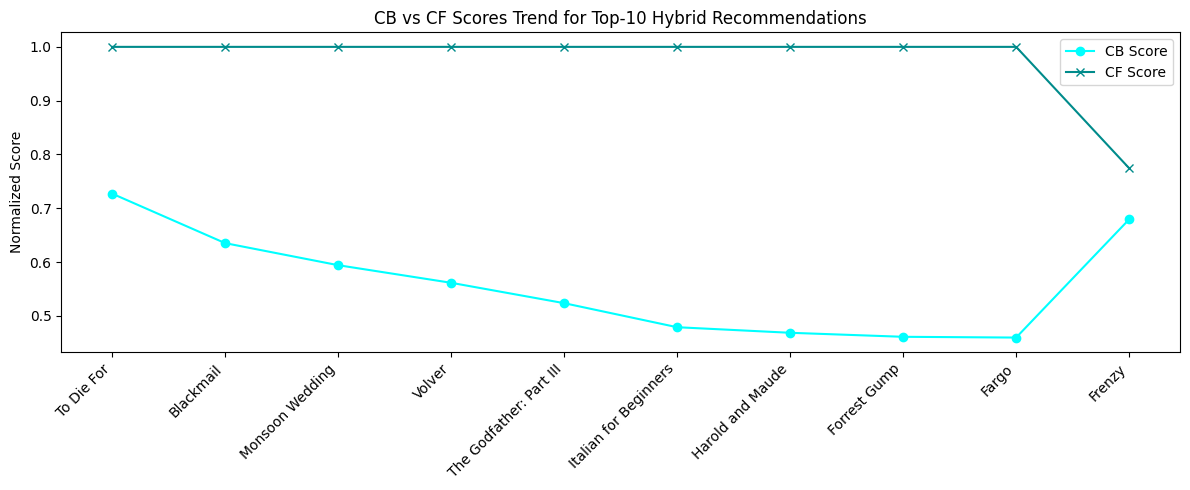

In [70]:
# CB VS CF PLOT
top_n = 10
indices = s_hyb.argsort()[::-1][:top_n]
titles = [df.loc[i, 'title'] for i in indices]
cb_scores = sCB_norm[indices]
cf_scores = sCF_norm[indices]

x = np.arange(len(titles))
width = 0.35
# Scatter plot of CB vs CF scores
plt.figure(figsize=(12,5))
plt.plot(cb_scores, marker='o', label='CB Score', color='cyan')
plt.plot(cf_scores, marker='x', label='CF Score', color='darkcyan')
plt.xticks(range(top_n), titles, rotation=45, ha='right')
plt.ylabel("Normalized Score")
plt.title(f"CB vs CF Scores Trend for Top-{top_n} Hybrid Recommendations")
plt.legend()
plt.tight_layout()
plt.show()
plt.show()


In [71]:
# SAVE 
import pickle
model = {
    "cb_sim": cb_sim,
    "vectorizer": vec,
    "movie_id_to_idx": movie_id_to_idx
}

with open("models/hybrid.pkl", "wb") as f:
    pickle.dump(model, f)


with open("models/hybrid_df.pkl", "wb") as f:
    pickle.dump(df, f)